In [22]:
#import all the libraries
import matplotlib.image as mpimage
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# from lesson_function import *
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


In [25]:
#load training cars and nocars images
cars = glob.glob('./dataset/vehicles/*/*.png')
nocars = glob.glob('./dataset/non-vehicles/*/*.png')
print('The number of cars images: ',len(cars))
print('The number of no-cars images',len(nocars))

The number of cars images:  8792
The number of no-cars images 8968


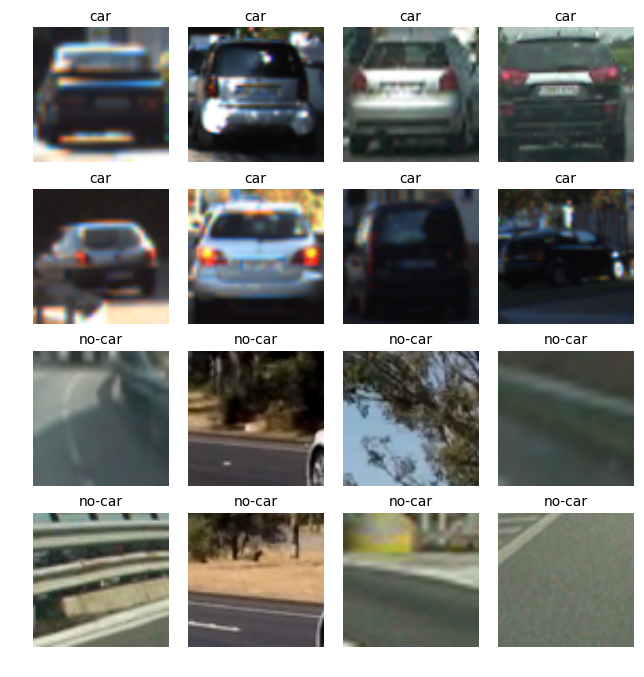

In [26]:
#visualize some data
fig,axs = plt.subplots(4,4,figsize=(8,8))
fig.subplots_adjust(hspace=0.2,wspace=0.001)
axs = axs.ravel()

for i in np.arange(8):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     print(img.shape)
    axs[i].axis('off')
    axs[i].set_title('car',fontsize=10)
    axs[i].imshow(img)
for i in np.arange(8,16):
    img = cv2.imread(nocars[np.random.randint(0,len(nocars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('no-car',fontsize=10)
    axs[i].imshow(img)

In [28]:
##HOG function
#Define a function to extract hog feature of an image
def get_hog_feature(img,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True):
    if vis == True:
        features,hog_image = hog(img,orientations=orient,
                                                    pixels_per_cell=(pix_per_cell,pix_per_cell),
                                                    cells_per_block=(cell_per_block,cell_per_block),
                                                    transform_sqrt=True,
                                                    visualise=vis,feature_vector=feature_vec)
        return features,hog_image
    else:
            features = hog(img,orientations=orient,
                                      pixels_per_cell=(pix_per_cell,pix_per_cell),
                                      cells_per_block=(cell_per_block,cell_per_block),
                                      transform_sqrt=True,visualise=vis,feature_vector=feature_vec)
            return features

In [31]:
#Define a function to extract binned color features 
def bin_spatial(img,size=(32,32)):
    #Use cv2.resize().ravel() to create the feature vector 
    features = cv2.resize(img,size).ravel()
    return features


In [35]:
#Define a function to compute color histogram features
def color_hist(img,nbins=32,bins_range=(0,256)):
    #Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0],bins=nbins,range=bins_range)
    channel2_hist = np.histogram(img[:,:,1],bins=nbins,range=bins_range)
    channel3_hist = np.histogram(img[:,:,2],bins=nbins,range=bins_range)
    
    #Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0],channel2_hist[0],channel3_hist[0]))
    return hist_features
    

In [92]:
#Define a funcion to extract features from an image,include binned color feature,color histogram feature and hog feature
def extract_features(img,color_space='RGB',spatial_size=(32,32),
                                    hist_bins=32,orient=9,
                                    pix_per_cell=8,cell_per_block=2,hog_channel=0,
                                    spatial_feat=True,hist_feat=True,hog_feat=True):
    #Create a list to append feature vectors to
    features = []
    # Apply color conversion if other color space than 'RGB
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
        elif color_space == 'YUV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    else:
        feature_img = np.copy(img)
     
    # Add spatial feature or not
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_img,size=spatial_size)
        features.append(spatial_features)
    #Add color hist feature or not
    if hist_feat == True:
        hist_features = color_hist(feature_img,nbins=hist_bins)
        features.append(hist_features)
    # Add hog feature or not
    if hog_feat == True:
        # Add all channels features or only one
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_img.shape[2]):
                hog_features.append(get_hog_feature(feature_img[:,:,channel],
                                                                                orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_feature(feature_img[:,:,hog_channel],
                                                                   orient,pix_per_cell,cell_per_block,
                                                                    vis=False,feature_vec=True)
        features.append(hog_features)
        
#         return features   
        return np.concatenate(features)
    

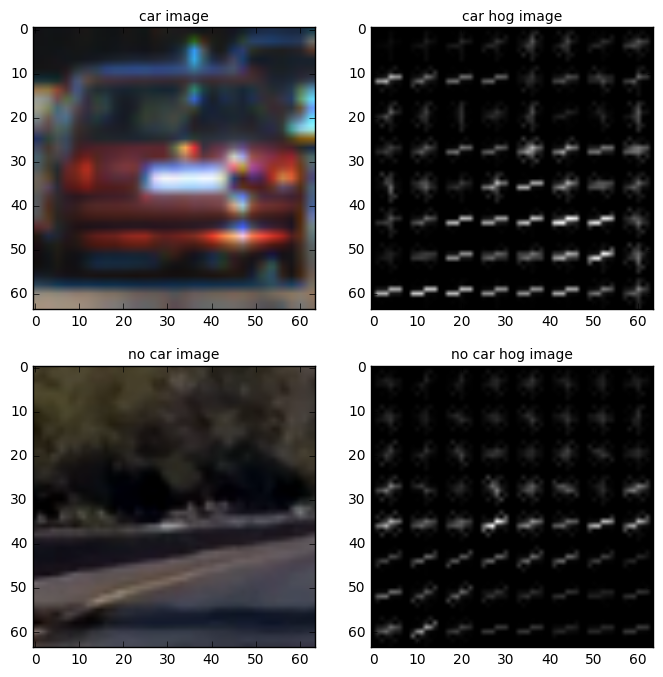

In [93]:
#Visualize HOG feature of car image and non-car image
car_img = cv2.imread(cars[np.random.randint(0,len(cars))])
car_img = cv2.cvtColor(car_img,cv2.COLOR_BGR2RGB)
# car_img = mpimage.imread(cars[np.random.randint(0,len(cars))])
_,car_hog_img = get_hog_feature(car_img[:,:,0],9,8,2,vis=True,feature_vec=True)

no_car_img = cv2.imread(nocars[np.random.randint(0,len(nocars))])
no_car_img = cv2.cvtColor(no_car_img,cv2.COLOR_BGR2RGB)
# no_car_img = mpimage.imread(cars[np.random.randint(0,len(nocars))])
_,no_car_hog_img = get_hog_feature(no_car_img[:,:,2],9,8,8,vis=True,feature_vec=True)


fig,axs = plt.subplots(2,2,figsize=(8,8))
fig.subplots_adjust(hspace=0.2,wspace=0.2)
axs = axs.ravel()
axs[0].imshow(car_img)
axs[0].set_title('car image',fontsize=10)
axs[1].imshow(car_hog_img,cmap='gray')
axs[1].set_title('car hog image',fontsize=10)

axs[2].imshow(no_car_img)
axs[2].set_title('no car image',fontsize=10)
axs[3].imshow(no_car_hog_img,cmap='gray')
axs[3].set_title('no car hog image',fontsize=10)


In [96]:
#Extract all the images features.Shuffle and split
#HOG parameters setting
hog_feat = True
color_space = 'HLS'
orient = 11
pix_per_cell = 9
cell_per_block = 2
hog_channel = 'ALL'

#binned spatial feature parameter
spatial_feat = True
spatial_size = (16,16)

#Color histogram feature parameter
hist_feat = True
hist_bins = 32

#Measure time for extracting all the features
t1 = time.time()

#Car feature list and non-car feature list
all_car_features = []
all_non_car_features = []

for imgpath in cars:
    car_img = mpimage.imread(imgpath)
    car_feature = extract_features(car_img,color_space=color_space,
                                                   spatial_size=spatial_size,hist_bins=hist_bins,orient=orient,
                                                    pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                     spatial_feat=True,hist_feat=True,hog_feat=True )
    all_car_features.append(car_feature)

print(len(all_car_features))
    
for imgpath in nocars:
    no_car_img = mpimage.imread(imgpath)
    no_car_feature = extract_features(no_car_img,color_space=color_space,
                                                   spatial_size=spatial_size,hist_bins=hist_bins,orient=orient,
                                                    pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                     spatial_feat=True,hist_feat=True,hog_feat=True )
    all_non_car_features.append(no_car_feature)

t2 = time.time()
print('Extracting features consumes ',round(t2-t1,2),' seconds')

print('The length of car features: ',len(all_car_features))
print('The lengthe of not-car features: ',len(all_non_car_features))

#Stack car features and not-car features together
all_features = np.vstack((all_car_features,all_non_car_features)).astype(np.float64)
print('The lengthe of all features: ',len(all_features))

#Fit a per-column scaler
scaler = StandardScaler().fit(all_features)
all_features_scaled = scaler.transform(all_features)

#Define labels vector
labels = np.hstack((np.ones(len(all_car_features)),np.zeros(len(all_non_car_features)))).astype(np.float64)
print('The length of all lables',len(labels))

#Split data into randomized training and test sets
rand_state = np.random.randint(0,100)
x_train,x_test,y_train,y_test = train_test_split(all_features_scaled,labels,test_size=0.2,random_state=rand_state)

print('The length of training dataset: ',len(x_train))
print('The length of test datast',len(y_train))

8792
Extracting features consumes  61.46  seconds
The length of car features:  8792
The lengthe of not-car features:  8968
The lengthe of all features:  17760
The length of all lables 17760
The length of training dataset:  14208
The length of test datast 14208


In [97]:
#Create a linear classifier
svc = LinearSVC()

#Measure training time
t1 = time.time()
svc.fit(x_train,y_train)
t2 = time.time()

print('Training time : ',round(t2-t1,2),'seconds')

#Check the score of SVC classifier
print('Training Accuracy of SVC ',svc.score(x_train,y_train))
print('Test Accuracy of SVC: ',svc.score(x_test,y_test))

#Check the prediction time
t1 = time.time()
num_predict = 10
print('SVC Predict: ',svc.predict(x_train[0:num_predict]))
print('Real label: ',y_train[0:num_predict])
t2 = time.time()
print(round(t2-t1,2),' seconds used to pridicet ',num_predict,' samples')

Training time :  14.04 seconds
Training Accuracy of SVC  1.0
Test Accuracy of SVC:  0.986768018018
SVC Predict:  [ 0.  0.  0.  0.  0.  1.  1.  0.  0.  1.]
Real label:  [ 0.  0.  0.  0.  0.  1.  1.  0.  0.  1.]
0.01  seconds used to pridicet  10  samples


In [99]:
#Save data and trained SVC model
pickle_file = 'train_test_data.p'
try:
    with open(pickle_file,'wb') as pfile:
        pickle.dump(
                            {
                                'x_train':x_train,
                                'y_train':y_train,
                                'x_test':x_test,
                                'y_test':y_test
                            } ,
                            pfile,pickle.HIGHEST_PROTOCOL
                            )
except Exception as e:
    print('Unable to save data,error happens: ',e)
    raise
print('Training and test data saved')

pickle_file = 'svc_classifier.p'
try:
    with open(pickle_file,'wb') as pfile:
        pickle.dump(
                            {'svc':svc},pfile,pickle.HIGHEST_PROTOCOL
                            )
except Exception as e:
    print('Error happens:',e)
    raise
print('SVC saved')

Training and test data saved
SVC saved
